
# Lab 4 — Wine Quality Data Mining (WineQT)

**Dataset:** WineQT.csv  
**Background info I used:** attribute definitions from the data description PDF


In [1]:
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 11

#Load the dataset
CSV_NAME = 'WineQT.csv'
df = pd.read_csv(CSV_NAME)
print('Loaded shape:', df.shape)
display(df.head())


Matplotlib is building the font cache; this may take a moment.


Loaded shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4



## 1) Quick data check / light cleaning

Just peeking at the columns to make sure they match the description, and doing tiny cleanup if needed (like dropping `Id` if it's just an identifier).


In [2]:

#Standard column expectations from WineQT description
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
display(df.dtypes)

#If there's an id column, it's not useful for modeling
if 'id' in df.columns:
    df = df.drop(columns=['id'], errors='ignore')

#Drop rows with missing target if any
if 'quality' in df.columns:
    df = df.dropna(subset=['quality'])

#Keep only numeric columns for stats/modeling
num_df = df.select_dtypes(include=[np.number]).copy()
print('Numeric shape after basic cleanup:', num_df.shape)
display(num_df.head())


fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                 float64
quality                   int64
id                        int64
dtype: object

Numeric shape after basic cleanup: (1143, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



## 2) Statistical Task — Correlation + Top 3 Features

I computed a correlation heatmap between quality and the chemical attributes, then grabbed the top 3 strongest correlations.


Top 3 features by |corr| with quality:
alcohol             0.484866
volatile_acidity    0.407394
sulphates           0.257710
Name: quality, dtype: float64


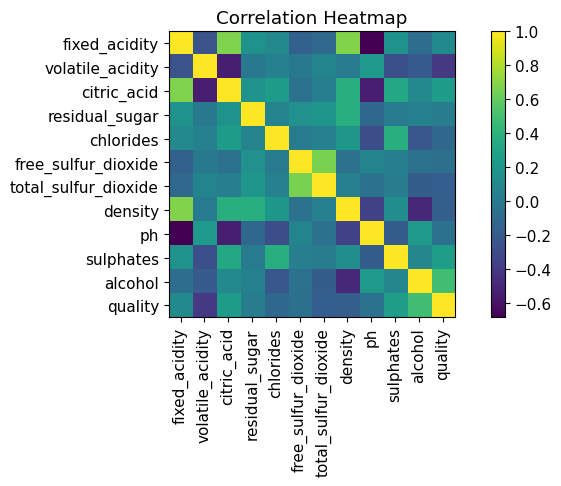

In [8]:

corr = num_df.corr(method='pearson')
#Sort by absolute correlation with quality
target_corr = corr['quality'].drop(labels=['quality']).abs().sort_values(ascending=False)
top3 = target_corr.head(3)
print('Top 3 features by |corr| with quality:')
print(top3)

#Basic heatmap using matplotlib
fig, ax = plt.subplots()
cax = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(cax)
ax.set_title('Correlation Heatmap')
plt.tight_layout()
import os; os.makedirs('figures', exist_ok=True)
plt.savefig('figures/correlation_heatmap.png', dpi=150)
plt.show()



**My takeaway:**  
The top 3 features most related to quality (by correlation) are shown above. These being of course alcohol with a .485, volatile_acidity with a .407, and sulphates with a .258.


## 3) Statistical Task — Bar Plots (4 attributes)

I picked four attributes and plotted mean value by quality so I can eyeball how they change as the quality increases.


,alcohol,sulphates,residual_sugar,volatile_acidity
quality,,,,
3,9.691667,0.550000,2.666667,0.897500
4,10.260606,0.637879,2.566667,0.700000
5,9.902277,0.613375,2.540476,0.585280
6,10.655339,0.676537,2.444805,0.504957
7,11.482634,0.743566,2.760140,0.393671
8,11.937500,0.766250,2.643750,0.410000


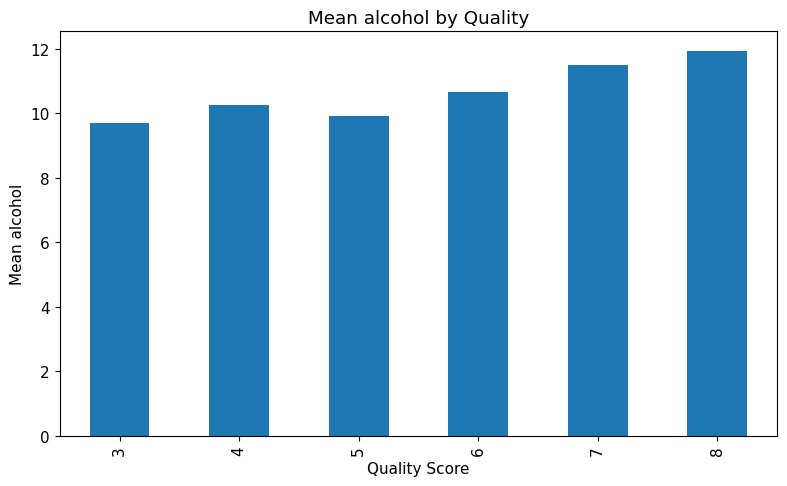

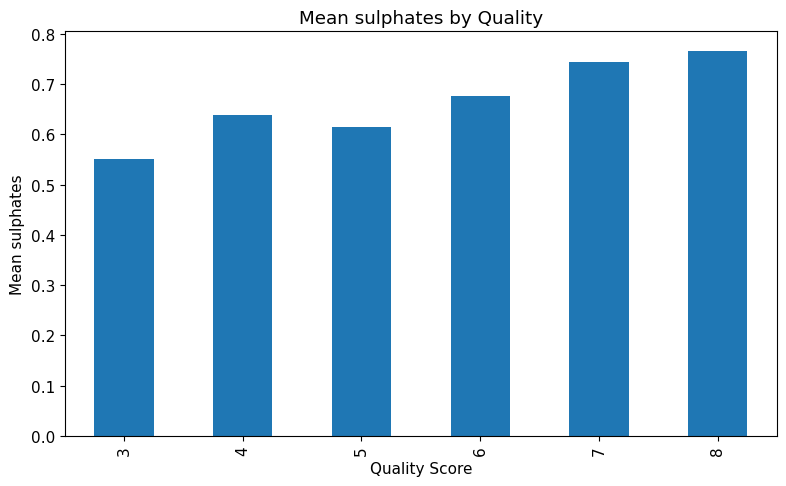

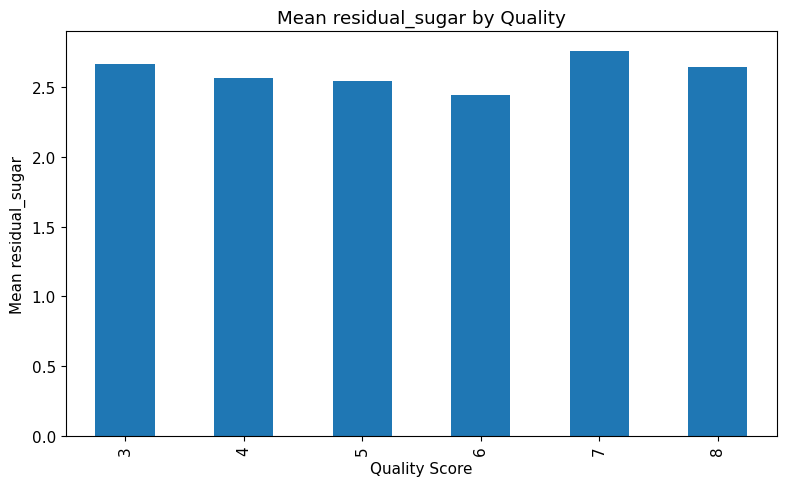

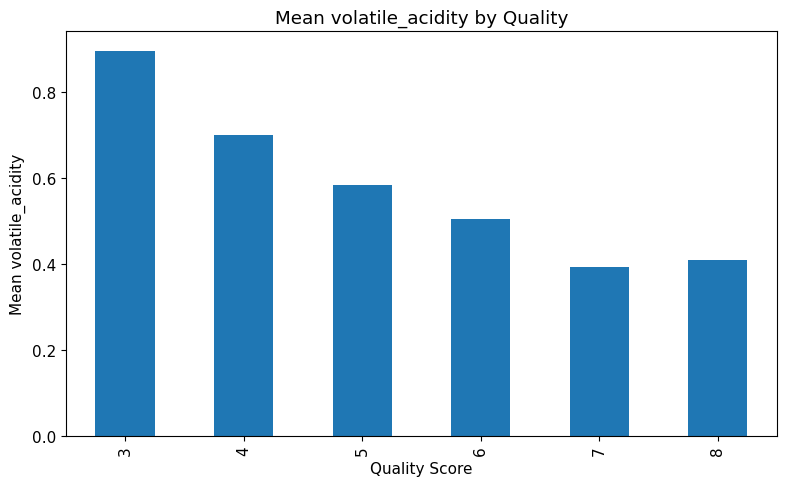

In [4]:

#Choose four attributes that exist in WineQT
candidates = ['alcohol', 'sulphates', 'residual_sugar', 'volatile_acidity']
attrs = [c for c in candidates if c in num_df.columns][:4]

grouped = num_df.groupby('quality')[attrs].mean().sort_index()
display(grouped)

for col in attrs:
    plt.figure()
    grouped[col].plot(kind='bar')
    plt.title(f'Mean {col} by Quality')
    plt.xlabel('Quality Score')
    plt.ylabel(f'Mean {col}')
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/bar_mean_{col}_by_quality.png', dpi=150)
    plt.show()



**My takeaway:**  
These bars help me guess which features climb or drop as quality goes up. For example, alcohol usually trends higher for better ratings, while volatile acidity often goes the other way.



## 4) Statistical Task — Line Plots (4 attributes)

Now I did line plots of mean attribute vs quality for four attributes (same data as the bar charts, just a different look).


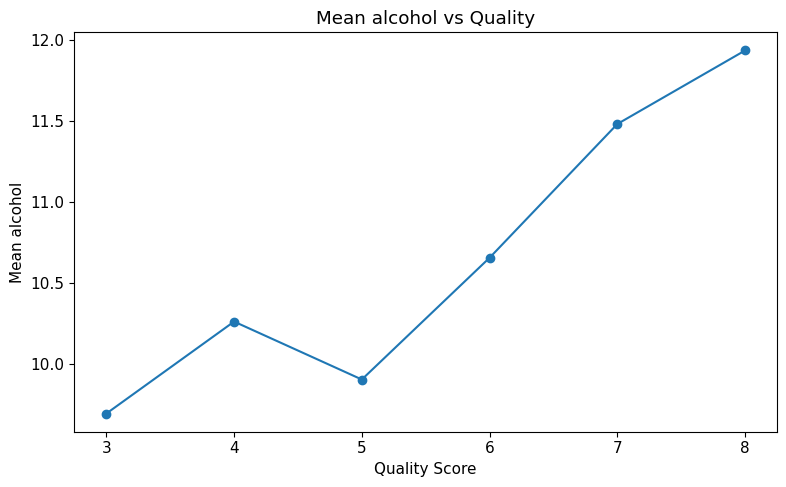

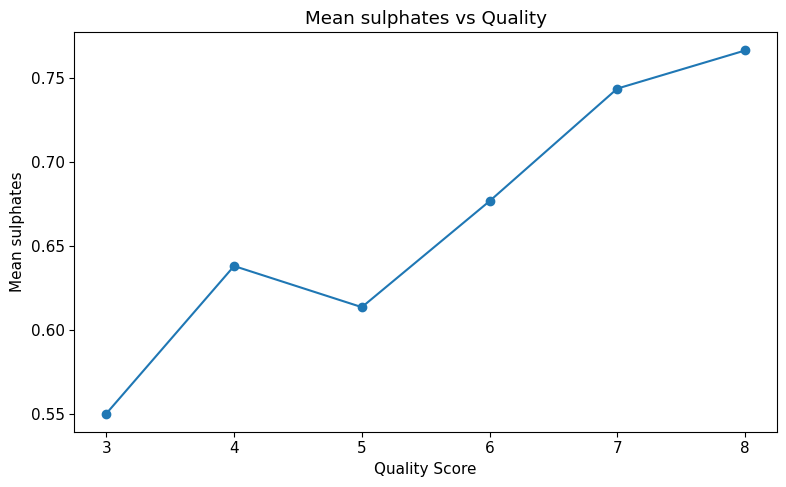

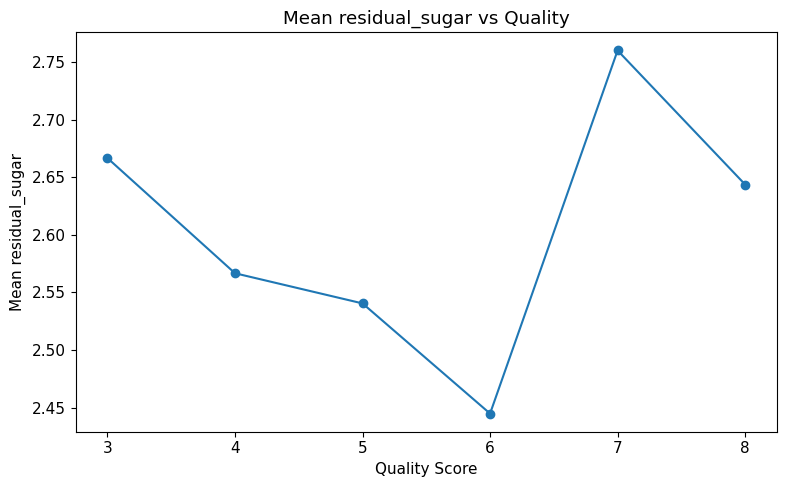

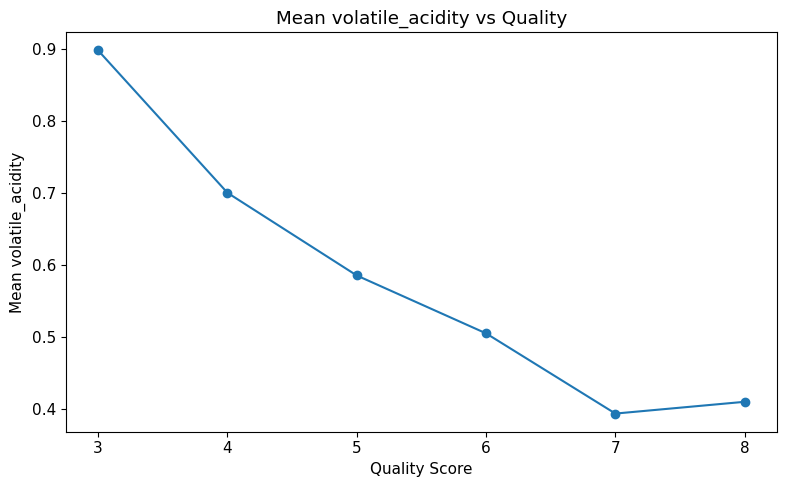

In [5]:

candidates = ['alcohol', 'sulphates', 'residual_sugar', 'volatile_acidity']
attrs = [c for c in candidates if c in num_df.columns][:4]

grouped = num_df.groupby('quality')[attrs].mean().sort_index()
for col in attrs:
    plt.figure()
    plt.plot(grouped.index, grouped[col], marker='o')
    plt.title(f'Mean {col} vs Quality')
    plt.xlabel('Quality Score')
    plt.ylabel(f'Mean {col}')
    plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/line_mean_{col}_vs_quality.png', dpi=150)
    plt.show()



**My takeaway:**  
The line plots made it pretty obvious which features slope up or down with quality.



## 5) Data Mining — K-Means for price categories
In order to get an idea of price categories the K-Means algorithm is used in order to figure that out. I used features the lab listed: fixed_acidity, volatile_acidity, citric_acid, chlorides, free_sulfur_dioxide, sulphates, alcohol


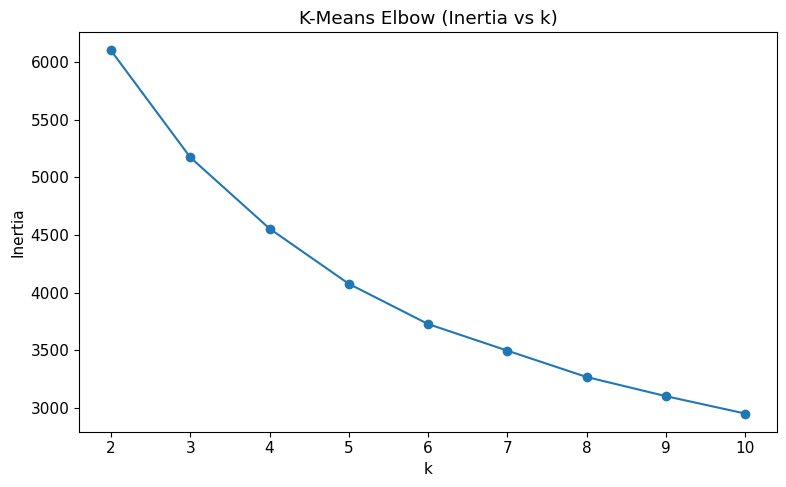

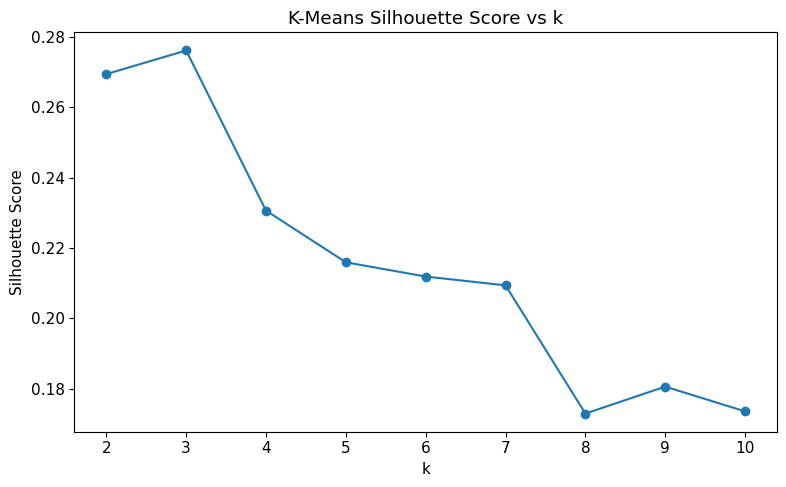

Chosen k by silhouette: 3


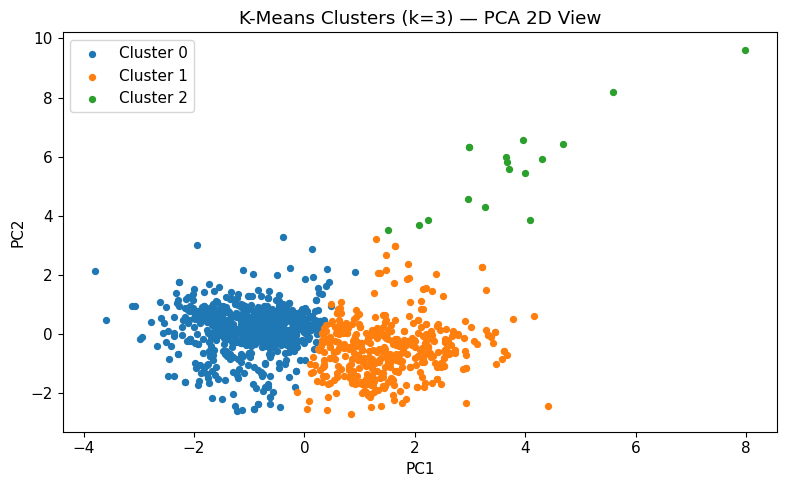

,count
0,703
1,423
2,17


In [6]:

kmeans_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides',
    'free_sulfur_dioxide', 'sulphates', 'alcohol'
]
kmeans_features = [c for c in kmeans_features if c in num_df.columns]

X = num_df[kmeans_features].dropna()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

#Try multiple k to pick a good number
ks = list(range(2, 11))
inertias = []
sils = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(Xs)
    inertias.append(km.inertia_)
    labels = km.labels_
    sil = silhouette_score(Xs, labels)
    sils.append(sil)

#Plot elbow (inertia)
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title('K-Means Elbow (Inertia vs k)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/kmeans_elbow.png', dpi=150)
plt.show()

#Plot silhouette
plt.figure()
plt.plot(ks, sils, marker='o')
plt.title('K-Means Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.savefig('figures/kmeans_silhouette.png', dpi=150)
plt.show()

#Pick best k by max silhouette
best_k = ks[int(np.argmax(sils))]
print('Chosen k by silhouette:', best_k)

#Final clustering and 2D visualization via PCA
km_final = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = km_final.fit_predict(Xs)

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xs)

plt.figure()
for lab in np.unique(labels):
    idx = labels == lab
    plt.scatter(X2[idx, 0], X2[idx, 1], label=f'Cluster {lab}', s=18)
plt.title(f'K-Means Clusters (k={best_k}) — PCA 2D View')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/kmeans_clusters_pca.png', dpi=150)
plt.show()

#Show simple cluster sizes
display((pd.Series(labels).value_counts().sort_index()
         .rename('count')
         .to_frame()))



**My takeaway:**  
I used the elbow curve and silhouette scores to argue for how many “price-like” groups to split into. I then plotted the clusters. The cluster counts table is there to show the group sizes.



## 6) Data Mining — KNN (predict quality)

Here I searched for the best number of neighbors (k) to predict quality. I used stratified 5-fold cross-validation, and tried k from 1 to 25. Then I plotted accuracy vs k to visualize everything.


Best k for KNN: 1 with CV accuracy = 0.5958


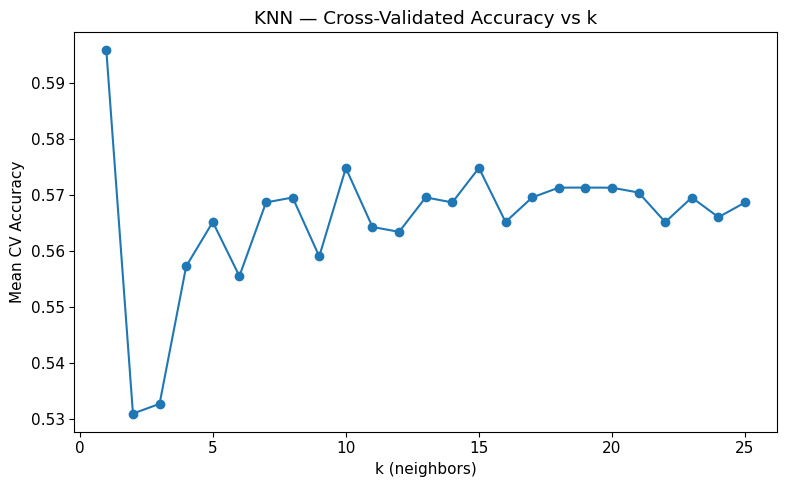

In [7]:

#Features
X_all = num_df.drop(columns=['quality']).dropna()
y_all = num_df.loc[X_all.index, 'quality'].astype(int)

scaler = StandardScaler()
Xs_all = scaler.fit_transform(X_all)

k_values = list(range(1, 26))
cv_scores = []

#Stratified splits because quality is discrete
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs_all, y_all, scoring='accuracy', cv=cv)
    cv_scores.append(scores.mean())

best_k_knn = k_values[int(np.argmax(cv_scores))]
print('Best k for KNN:', best_k_knn, 'with CV accuracy =', round(max(cv_scores), 4))

plt.figure()
plt.plot(k_values, cv_scores, marker='o')
plt.title('KNN — Cross-Validated Accuracy vs k')
plt.xlabel('k (neighbors)')
plt.ylabel('Mean CV Accuracy')
plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/knn_k_tuning.png', dpi=150)
plt.show()



**My takeaway:**  
I used cross-validation to avoid overfitting on a single split. The plot makes it clear which k worked best for the dataset. Usually very small k overfits and very large k underfits so the best k tends to be somewhere in the middle.
